### Feathers in Focus: AML 2025 Kaggle Challenge 🪶
### Athina Papatriantafyllou • Alexandra Holíková • Buğra Sipahioğlu

### Setup Instructions
> **Setup Commands (in terminal):**
> ```bash
> python -m venv venv
> source venv/bin/activate
> pip install -r requirements.txt
> ```
> **Download the data and unzip it under "data/Raw":** https://www.kaggle.com/competitions/aml-2025-feathers-in-focus/data

### Import the Libraries

In [23]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageStat
from sklearn.model_selection import train_test_split
from torchvision.io import decode_image
from torch.utils.data import Dataset
from torchvision.transforms import v2
import torch

### Load the data

In [2]:
# Load the training and test sets
train_df = pd.read_csv("../data/Raw/train_images.csv")
test_df = pd.read_csv("../data/Raw/test_images_path.csv")
class_names = np.load("../data/Raw/class_names.npy", allow_pickle=True).item()

# Load attributes
attributes = np.load("../data/Raw/attributes.npy", allow_pickle=True)
with open("../data/Raw/attributes.txt", "r") as f:
    attribute_names = [line.strip().split(' ', 1)[1] for line in f.readlines()]

# Print the data summary
print("Loading the data....")
print(f"-Train Size: {len(train_df)} \n-Test Size: {len(test_df)} \n-Number of Classes: {len(class_names)}")
print(f"-Attributes: {len(attribute_names)} (shape: {attributes.shape if hasattr(attributes, 'shape') else 'N/A'})")


Loading the data....
-Train Size: 3926 
-Test Size: 4000 
-Number of Classes: 200
-Attributes: 312 (shape: (200, 312))


### Explore the data

Random images (with their labels)from the training set:


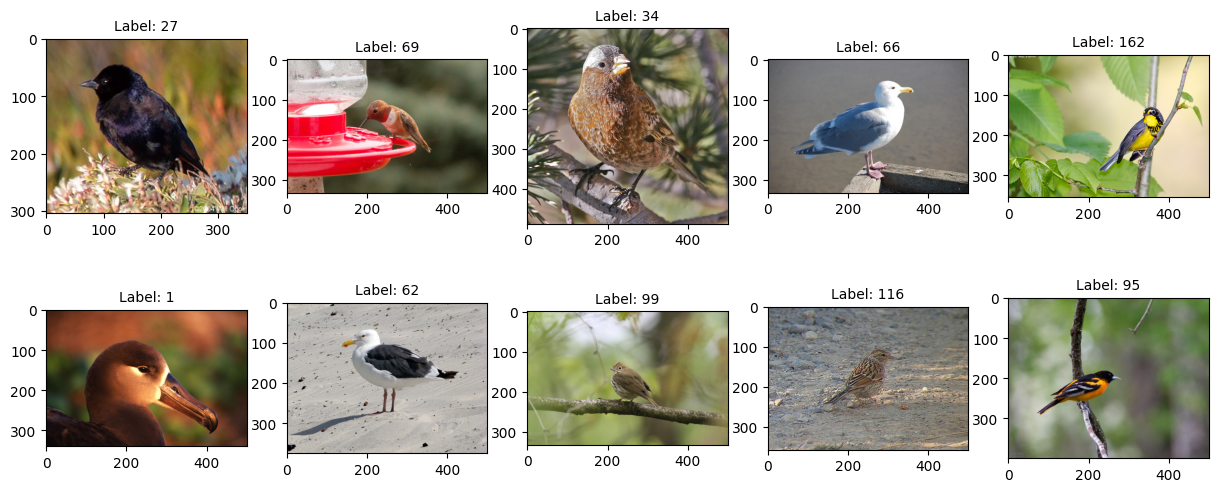

In [3]:
# Inspect the training set by showing 10 random images
print("Random images (with their labels)from the training set:")
samples = train_df.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, (_, row) in zip(axes.flat, samples.iterrows()):
    img = Image.open(f"../data/Raw/train_images{row['image_path']}")
    label_name = class_names.get(row['label'], f"Label: {row['label']}")
    ax.set_title(label_name, fontsize=10)
    ax.imshow(img)
plt.show()

Checking 3926 images' dimensions... 
-Width: min=140, max=500, mean=467.78
-Height: min=120, max=500, mean=385.37


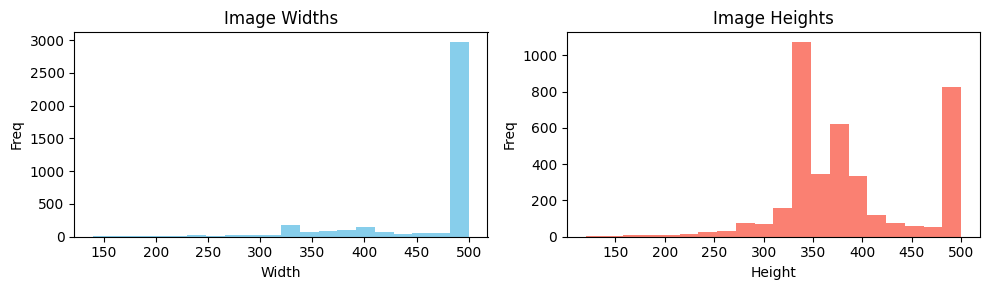

In [4]:
# Check image dimensions in the training set (concise version)
sizes = [Image.open(f"../data/Raw/train_images{p}").size for p in train_df['image_path']]
widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]
print(f"Checking {len(widths)} images' dimensions... \n-Width: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.2f}\n-Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.2f}")

fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].hist(widths, bins=20, color='skyblue'), axs[0].set(title='Image Widths', xlabel='Width', ylabel='Freq')
axs[1].hist(heights, bins=20, color='salmon'), axs[1].set(title='Image Heights', xlabel='Height', ylabel='Freq')
plt.tight_layout()
plt.show()

In [5]:
# Inspect the attributes
attributes_df = pd.DataFrame({'Index': range(len(attribute_names)), 'Attribute Name': attribute_names})
print("Attributes:")
display(attributes_df.head(10))

Attributes:


,Index,Attribute Name
0,0,has_bill_shape::curved_(up_or_down)
1,1,has_bill_shape::dagger
2,2,has_bill_shape::hooked
3,3,has_bill_shape::needle
4,4,has_bill_shape::hooked_seabird
5,5,has_bill_shape::spatulate
6,6,has_bill_shape::all-purpose
7,7,has_bill_shape::cone
8,8,has_bill_shape::specialized
9,9,has_wing_color::blue


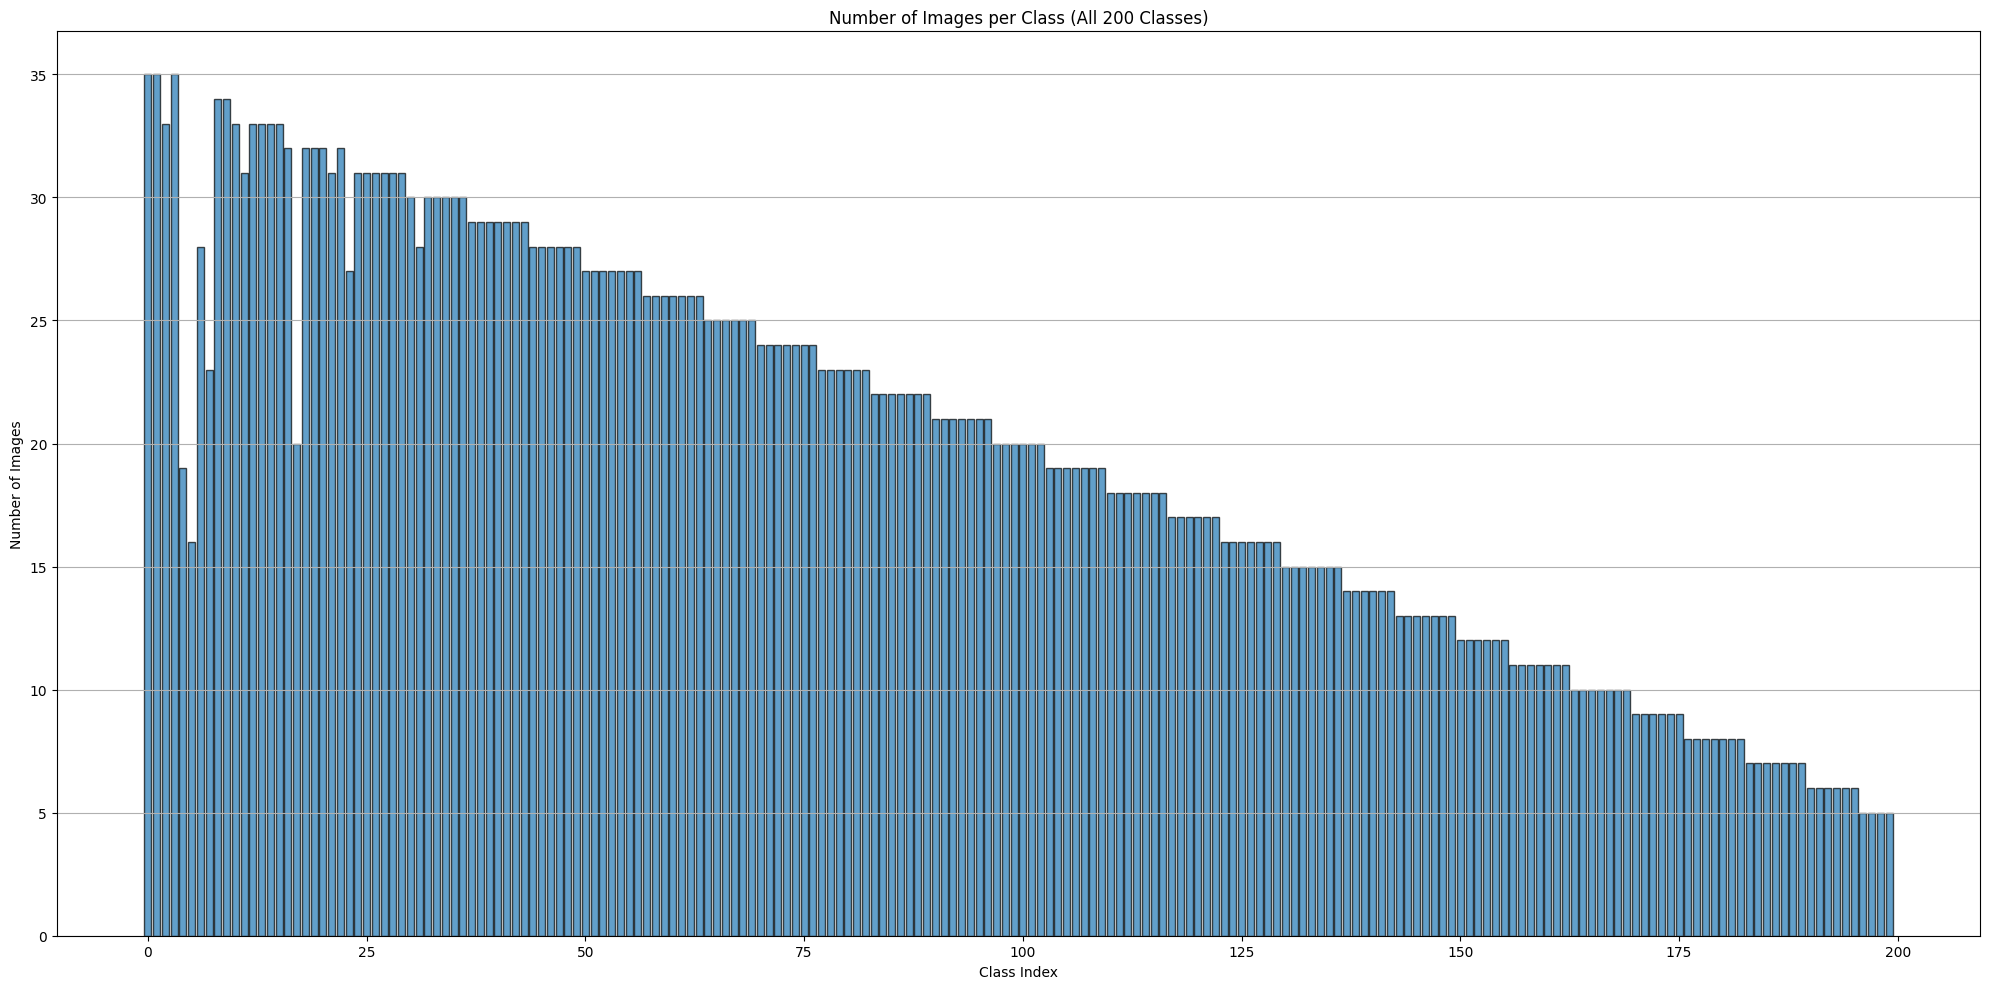

Statistics:
-Number of unique classes: 200
-Average number of images per class: 19.63
-Standard deviation of images per class: 8.39 (Lower the std, more balanced the dataset)
-Minimum number of images per class: 5
-Maximum number of images per class: 35


In [6]:
# Plot the class distribution to inspect the balance
class_counts = train_df['label'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(20, 10))

# Show the count for each class
ax.bar(range(len(class_counts)), class_counts.values, tick_label=None, edgecolor='k', alpha=0.7)
ax.set_xlabel('Class Index')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class (All 200 Classes)')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

# Statistics
print("Statistics:")
print(f"-Number of unique classes: {len(class_names)}")
print(f"-Average number of images per class: {class_counts.mean():.2f}")
print(f"-Standard deviation of images per class: {class_counts.std():.2f} (Lower the std, more balanced the dataset)")
print(f"-Minimum number of images per class: {class_counts.min()}")
print(f"-Maximum number of images per class: {class_counts.max()}")


In [7]:
# Check for Corrupted Images

# Check Training Set
corrupt_counter_train = 0
for idx, row in train_df.iterrows():
    img_path = f"../data/Raw/train_images{row['image_path']}"
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        corrupt_counter_train += 1

# Check Test Set
corrupt_counter_test = 0
for idx, row in test_df.iterrows():
    img_path = f"../data/Raw/test_images{row['image_path']}"
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        corrupt_counter_test += 1

# Print the results
print(f"Total corrupt images in training set: {corrupt_counter_train}")
print(f"Total corrupt images in test set: {corrupt_counter_test}")


Total corrupt images in training set: 0
Total corrupt images in test set: 0


In [26]:
# Check the color stats for all training images
def get_color_stats(image_path):
    img = Image.open(image_path).convert('RGB')
    stat = ImageStat.Stat(img)
    brightness = sum(stat.mean) / len(stat.mean)
    contrast = sum(stat.stddev) / len(stat.stddev)
    saturation = max(stat.mean) - min(stat.mean)
    return brightness, contrast, saturation

stats = [get_color_stats(f"../data/Raw/train_images{p}") for p in train_df['image_path']]
brightnesses = [s[0] for s in stats]
contrasts = [s[1] for s in stats]
saturations = [s[2] for s in stats]

print(f"Color Statistics (training set, n={len(train_df)}):")
print(f"- Brightness: mean={np.mean(brightnesses):.2f}, std={np.std(brightnesses):.2f}, range=[{min(brightnesses):.2f}, {max(brightnesses):.2f}]")
print(f"- Contrast: mean={np.mean(contrasts):.2f}, std={np.std(contrasts):.2f}, range=[{min(contrasts):.2f}, {max(contrasts):.2f}]")
print(f"- Saturation: mean={np.mean(saturations):.2f}, std={np.std(saturations):.2f}, range=[{min(saturations):.2f}, {max(saturations):.2f}]")
print("\nInterpretation:")
print("- High variance values indicate the images already have diverse properties.\n- Hence, we don't need to use (high parameters for) ColorJitter.")

Color Statistics (training set, n=3926):
- Brightness: mean=121.81, std=33.72, range=[18.69, 244.95]
- Contrast: mean=47.22, std=14.21, range=[11.51, 106.21]
- Saturation: mean=32.34, std=25.01, range=[0.00, 178.80]

Interpretation:
- High variance values indicate the images already have diverse properties.
- Hence, we don't need to use (high parameters for) ColorJitter.


### Prepare the Data for Training

In [ ]:
# Extract image paths and labels
X = train_df['image_path'].values
y = train_df['label'].values       

# Look at indices of labels (Y)
print("Before correction:")
print("- y indices min:", y.min())
print("- y indices max:", y.max())

# Since the labels start from 1, convert them to 0-indexed
y = y - 1

print("After correction:")
print("- y indices min:", y.min())
print("- y indices max:", y.max())

# Split the data into training and validation sets (80% train, 20% validation)
X_test = test_df['image_path'].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=45, # keep the same random state across runs for reproducibility
    stratify=y  # Maintains class distribution in both sets
)

Before correction:
- y indices min: 1
- y indices max: 200
After correction:
- y indices min: 0
- y indices max: 199


### Create Custom Dataset for PyTorch

In [15]:
# Pytorch needs a custom dataset to load and transform the data
class FeatherImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transformation=None, target_transformation=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transformation = transformation
        self.target_transformation = target_transformation
    
    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, i):
        image_path = self.image_paths[i]
        image_label = self.image_labels[i]  
        image = decode_image(image_path)
        if self.transformation:
            image = self.transformation(image)
        if self.target_transformation:
            image_label = self.target_transformation(image_label)
        return image, image_label

### Define the transformations

In [ ]:
# Transformations for training set
transformation_training = v2.Compose([

    # Randomly crop to 224x224 from a resized area of the image.
    # Scale controls how much of the original image area we keep (can be tuned).
    # Since feathers require fine details, I tried to keep the scale high.
    # Antialias=True is used to improve the quality of the resized image.
    v2.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), antialias=True),
    
    # Random horizontal flip (can be tuned, higher the value more data augmentation)
    v2.RandomHorizontalFlip(p=0.5), 
    
    # Random rotation (can be tuned, higher the value more data augmentation)
    v2.RandomRotation(degrees=15), 
    
    # Color jitter (can be tuned, higher the value more data augmentation.
    # Kept it small since the stats of the training images are already diverse.
    # Strong color augmentations can distort the images and make the model more confused.
    v2.ColorJitter(brightness=0.2, contrast=0.25, saturation=0.25, hue=0.15), 
    
    # Convert to float32 and scale to [0,1] (also converts to tensor)
    v2.ToDtype(torch.float32, scale=True),
    
    # Normalize the image (can be changed, but if we are using ImageNet pretrained models, we should keep it)
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# Transformations for validation set
transformation_validation = v2.Compose([
    # Resize the image to 224x224 (can be tuned but I removed randomness here for consistent validation)
    v2.Resize(256, antialias=True),

    # Center crop to 224x224 (matches the training set)
    v2.CenterCrop(224),
    
    # Convert to float32 and scale to [0,1] (also converts to tensor)
    v2.ToDtype(torch.float32, scale=True),
     
    # Normalize the image (this must match the training normalization)
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])